### This file decribes how to get scrape a working csv-file from wikinews.org

# IT NEED A LOT OF STUFF NOT IMPLEMENTED COMPLITELY

Table taken from: https://github.com/several27/FakeNewsCorpus - go there for better table formating

| Type | Tag | Count (so far) | Description|
| ------------- |-------------|:-------------:|:-------------:|
| **Fake News** | fake | 928,083 | Sources that entirely fabricate information, disseminate deceptive content, or grossly distort actual news reports |
| **Satire** | satire | 146,080 | Sources that use humor, irony, exaggeration, ridicule, and false information to comment on current events. |
| **Extreme Bias** | bias | 1,300,444 | Sources that come from a particular point of view and may rely on propaganda, decontextualized information, and opinions distorted as facts. |
| **Conspiracy Theory** | conspiracy | 905,981 | Sources that are well-known promoters of kooky conspiracy theories. |
| **State News** | state | 0 | Sources in repressive states operating under government sanction. |
| **Junk Science** | junksci | 144,939 | Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims. |
| **Hate News** | hate | 117,374 | Sources that actively promote racism, misogyny, homophobia, and other forms of discrimination. |
| **Clickbait** | clickbait | 292,201 | Sources that provide generally credible content, but use exaggerated, misleading, or questionable headlines, social media descriptions, and/or images. |
| **Proceed With Caution** | unreliable | 319,830 | Sources that may be reliable but whose contents require further verification. |
| **Political** | political | 2,435,471 | Sources that provide generally verifiable information in support of certain points of view or political orientations. |
| **Credible** | reliable | 1,920,139 | Sources that circulate news and information in a manner consistent with traditional and ethical practices in journalism (Remember: even credible sources sometimes rely on clickbait-style headlines or occasionally make mistakes. No news organization is perfect, which is why a healthy news diet consists of multiple sources of information). |

In [1]:
# Follow the link below:
# https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
# https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/



import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string

### Import and get basic information about the data

First we import the data and get an idea about how it it structured and so on such that we can better understand what has to be done.

- Below we import and create a type_id colum (might remove later)


In [195]:
# Liar dataset
file_name = "liar_train"
filepath  = '../Data_git_ignore/'+file_name+'.tsv'

# Create df for the entire file
entire_df = pd.read_csv(filepath,
                        index_col = [0],
                        sep='\t',
                        encoding='utf-8',
                        names=["type", "content", "subject(s)", "speaker", "speaker's job title.", "state info.", "party affiliation.", "a", "b", "c", "d", "e", "f"]
                        )
entire_df = entire_df[['type', 'content']]

# Make index to Int
entire_df.reset_index(inplace = True, drop = True)

In [ ]:
# Kaggle dataset - in it to 
file_name = "test_set"
filepath  = '../Data_git_ignore/'+file_name+'.json'

# Create df for the entire file
entire_df = pd.read_json(filepath)
entire_df = entire_df[['type', 'content']]

# Make index to Int
entire_df.reset_index(inplace = True, drop = True)

## CHange types to be only fake or reliable
fake     = 3

reliable = 7

fake     = false, pants-fire
reliable = true, mostly-true

Exclude  = barely-true, half-true

In [196]:
# Only use 2 labels after
fake_types     = ['false', 'pants-fire']
reliable_types = ['true', 'mostly-true']
exclude_types  = ['barely-true', 'half-true']

# Change fake_types to fake
for t in fake_types:
    # Change to fake
    entire_df.type = entire_df.type.replace(t , 3)

# Change reliable_types to reliable
for t in reliable_types:
    # Change to fake
    entire_df.type = entire_df.type.replace(t , 7)

for t in exclude_types:
    entire_df.drop(entire_df[entire_df.type == t].index, inplace=True)

In [197]:
### Below are overall integrity cleaning ###

# # Drop non-numeric id's
# entire_df['id'] = pd.to_numeric(entire_df['id'], errors = 'coerce', downcast = 'integer')
# entire_df.dropna(subset=['id'], inplace = True)

# # Set id to int
# entire_df['id'] = entire_df['id'].astype(int)

# content has to be unique
entire_df.drop_duplicates(['content'], inplace = True)

# Drop rows wiht type-nan´
entire_df = entire_df[entire_df['type'].notna()]

# # Create type_id column
# entire_df['type_id'] = entire_df.groupby(['type']).ngroup()

entire_df

,type,content
0,3,Says the Annies List political group supports ...
2,7,"Hillary Clinton agrees with John McCain ""by vo..."
3,3,Health care reform legislation is likely to ma...
5,7,The Chicago Bears have had more starting quart...
9,7,Says GOP primary opponents Glenn Grothman and ...
...,...,...
10233,3,Mayor Fung wants to punish our childrens educa...
10235,7,There are a larger number of shark attacks in ...
10236,7,Democrats have now become the party of the [At...
10238,3,On lifting the U.S. Cuban embargo and allowing...


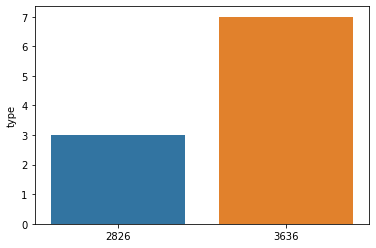

In [201]:
### Show info about "entire"-dataset ###

# Show rows for each type
types = entire_df.groupby('type').content.count()
sns.barplot(types.values, types.index)

In [200]:
### SELECT SIZE OF -> sub-dataset ###

# This can generate a dataset with random purmutation and a max size for each type(can be smaller if desired max is not possible)

# max size for type
max_size = 5000
# Labels to include - ['fake', 'satire', 'bias', 'conspiracy', 'state', 'junksci', 'hate', 'clickbait', 'unreliable', 'political', 'reliable'] - all labels
use_types = [7,3]
# Random seed
rnd = 1

# initialize dataframes
df = pd.DataFrame(columns = entire_df.columns)

# add type to test splits
for t in use_types:

    # type size
    type_size = entire_df['type'].loc[entire_df['type'] == t].value_counts().min()

    # set size of type slice
    if type_size < max_size:
        tmp = entire_df.loc[entire_df['type'] == t].sample(n = type_size, random_state=rnd)
    else:
        tmp = entire_df.loc[entire_df['type'] == t].sample(n = max_size, random_state=rnd)
    
    # add tmp to dataframes
    df = pd.concat([df, tmp])
    
    # print split shape
    print("=>", t, tmp.shape)

print("\n[Final sub-dataset]\nwhole ==>", df.shape)

=> 7 (3636, 2)
=> 3 (2826, 2)

[Final sub-dataset]
whole ==> (6462, 2)


,type,content
count,790,790
unique,2,790
missing,0,0


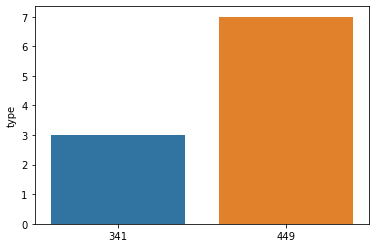

In [185]:
### Show info about sub-dataset ###

# Show rows for each type
types = df.groupby('type').content.count()
sns.barplot(types.values, types.index)

# Show "descibe" data
describe_df = df.describe(include=[np.object]).head(2)
nan_df = df.isna().sum()
describe_df.loc['missing'] = nan_df
describe_df

In [187]:
# ### REMOVE AND REPLACE -> NaN/Empty elmements ###

# # Remove rows where columns are NaN
# df.dropna(subset=['title'])

# # Replace NaN-elements with 'NULL'
# df = df.fillna('NULL')

# # Replace "['']" - these are NaN 
# regex = r"\[''\]"
# df['meta_keywords'] = df['meta_keywords'].replace(to_replace=regex, value='NULL', regex=True)

# # Replace '_' or '' (empty str) from "string-like" columns - these are NaN
# regex = r"^$|^ +"
# columns = ['domain', 'type', 'url', 'content', 'title', 'authors', 'keywords', 'meta_description', 'tags', 'summary', 'source']
# df[columns] = df[columns].replace(to_replace=regex, value='NULL', regex=True)

### Dataset Preparation

Here we start the cleaning process. There are a lot of steps and the code can be a little complicated. Some steps have to be before others as they overrule the previous 

- how to implement is still up for debate as it can be smart to use small cells for each step or get all in one big cleaning step but display when they are done
- **READ** all excersice 1-7 on KU

### Common data cleaning steps
- make text all lower case
- remove puntuiation
- remove numerical values
- remove common non-sensial text(/n)
- tokanize text

### # steps that need to be included
- -NUM -DATE -EMAIL -URL
- replace nan with 'NULL'

### Text blob cleaning
The first cleaning-step is wokring on text blobs ie. all text at the same time

In [188]:
# # working with content as a series
series_content = df['content']

### Order matters - (not final order of pipeline)
### Overall preprocessing

# lower_cast - NEEDED? - DONE by many libs
%time print("\n (lower_cast)"); series_content = series_content.str.lower()

### replace [name] with tokens in text ###

# Email_replace
regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
%time print("\n (Email_replace)"); series_content = series_content.replace(to_replace=regexEmail, value=' EMAIL ', regex=True)

# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
%time print("\n (URL_replace)"); series_content = series_content.replace(to_replace=regexURL, value=' URL ', regex=True)

# HTML_replace
regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
%time print("\n (HTML_replace)"); series_content = series_content.replace(to_replace=regexHTML, value=' HTML ', regex=True)

# Date_replace - NOT DONE
# - name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
# - day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
# - year         ([12][0-9]{3})         - Years from 1000 to 2999
regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
%time print("\n (Date_replace)"); series_content = series_content.replace(to_replace=regexDate, value=' DATE ', regex=True)

# Number_replace
regexNum = r"[0-9][0-9,\.]+" # nums with [0-9] and [,.]
%time print("\n (Number_replace)"); series_content = series_content.replace(to_replace=regexNum, value=' NUM ', regex=True)

### string removal functions ###

# Punctuation_remove
regexPunkt = r"[!“”\"#$%&()*+,\-–.…\/:;<=>?@[\\\]^_`{|}~'\’\'»]" # also removes: " ' " which means ie. it's -> its - remove \' from regwex if not needed
%time print("\n (Punctuation_remove)"); series_content = series_content.replace(to_replace=regexPunkt, value='', regex=True)

# whitespace_remove
regexWhiteSpace = r"\s+|\\n+"
%time print("\n (whitespace_remove)"); series_content = series_content.replace(to_replace=regexWhiteSpace, value=' ', regex=True)

# # Non_ASCII_remove - Maybe a step too much
# %time print("\n (Non_ASCII_remove)"); series_content = series_content.str.encode('ascii', 'ignore').str.decode('ascii')

# After all steps
print("\n (Done cleaning)")


 (lower_cast)
Wall time: 1e+03 µs

 (Email_replace)
Wall time: 3 ms

 (URL_replace)
Wall time: 11.9 ms

 (HTML_replace)
Wall time: 1 ms

 (Date_replace)
Wall time: 32 ms

 (Number_replace)
Wall time: 2 ms

 (Punctuation_remove)
Wall time: 2 ms

 (whitespace_remove)
Wall time: 7 ms

 (Done cleaning)


In [189]:
series_content.iloc[0]

'hackers broke into virginias prescriptiondrug database and obtained more than DATE million patient records and a total of nearly NUM million prescriptions'

In [191]:
# # Lexemize content

# # imports used
# import swifter
# import spacy
# nlp = spacy.load('en_core_web_sm')
# # nlp = spacy.load('xx_ent_wiki_sm')

# # # Lemma function
# # def lemmatizer(text):        
# #     sent = []
# #     doc = nlp(text)
# #     for word in doc:
# #         sent.append(word.lemma_)
# #     # return string_list
# #     return "{" + str(sent)[1:-1] + "}"

# # Lemma function
# def lemmatizer(text):        
#     sent = []
#     doc = nlp(text)
#     for word in doc:
#         sent.append(word.lemma_)
#     # return string_list
#     return sent

# # Assingn Series for return
# content_tokenize_series = series_content.swifter.apply(lambda x: lemmatizer(x), axis=1)

# Faster but not as precise
content_tokenize_series = series_content.str.split()

regexStrList = r"\["
content_tokenize_series = content_tokenize_series.replace(to_replace=regexStrList, value='{', regex=True)
regexStrList = r"\]"
content_tokenize_series = content_tokenize_series.replace(to_replace=regexStrList, value='}', regex=True)

In [33]:
content_tokenize_series

1496    [we, are, witnessing, a, great, turning, inwar...
8192    [more, than, a, parade, and, my, new, manifest...
5154    [dallas, gun, buyback, program, countered, wit...
2272    [by, paul, j, balles, many, industries, that, ...
2198    [enterprise, vsat, market, global, research, a...
                              ...                        
3304    [advertisement, as, you, see, i, could, go, on...
9766    [i, wrote, this, last, night, after, i, learne...
8698    [now, this, is, how, you, earn, civil, rights,...
1935    [advertisement, put, option, on, america, part...
7002    [in, my, previous, piece, progressive, tea, pa...
Name: content, Length: 240, dtype: object

## Insert into dataframe and write to csv

In [193]:
# Insert series with changes into dataframe write csv-file

df['content_tokenize'] = content_tokenize_series


df['content'] = series_content

# write csv
df.to_csv('../Data_git_ignore/liar_train.csv', index=True, header=True)